In [146]:
# Import necessary files
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

In [2]:
# Read row files data
rowConv = pd.read_csv('data/table_A_conversions.csv')
rowAttr = pd.read_csv('data/table_B_attribution.csv')

In [3]:
# print files details
print(rowConv.info())
print('\n')
print(rowAttr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79643 entries, 0 to 79642
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Conv_Date  79643 non-null  object 
 1   Revenue    79643 non-null  float64
 2   User_ID    77347 non-null  object 
 3   Conv_ID    79643 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.4+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211060 entries, 0 to 211059
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Channel   211060 non-null  object 
 1   IHC_Conv  211060 non-null  float64
 2   Conv_ID   211060 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.8+ MB
None


In [4]:
# Merge two tables based on Conv_ID with innerjoin to get common data only
rowMerged = rowConv.merge(rowAttr, on='Conv_ID', how='inner')

In [5]:
# Explore new table
print('Info\n')
print(rowMerged.info())
print('\n------------------------------------\nHead\n')
print(rowMerged.head())
print('\n------------------------------------\nNumber of unique categories in each field\n')
print(rowMerged.nunique())
print('\n------------------------------------\nNumber of missing values and its portion of the data\n')
print(pd.DataFrame({'count':rowMerged.isnull().sum(), 'Pct% of the data':rowMerged.isnull().mean() * 100}))

Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211060 entries, 0 to 211059
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Conv_Date  211060 non-null  object 
 1   Revenue    211060 non-null  float64
 2   User_ID    204422 non-null  object 
 3   Conv_ID    211060 non-null  object 
 4   Channel    211060 non-null  object 
 5   IHC_Conv   211060 non-null  float64
dtypes: float64(2), object(4)
memory usage: 11.3+ MB
None

------------------------------------
Head

    Conv_Date    Revenue                                   User_ID  \
0  2017-03-06   47.00000  5094298f068196c5349d43847de5afc9125cf989   
1  2017-03-02   98.00004                                       NaN   
2  2017-03-02   98.00004                                       NaN   
3  2017-03-02   98.00004                                       NaN   
4  2017-03-02  180.35300                                       NaN   

                                 

In [6]:
# Remove missing data since only 6638 rows have missing data (about 3%)
rowMerged.dropna(axis=0, how='any', inplace=True)
rowMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204422 entries, 0 to 211059
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Conv_Date  204422 non-null  object 
 1   Revenue    204422 non-null  float64
 2   User_ID    204422 non-null  object 
 3   Conv_ID    204422 non-null  object 
 4   Channel    204422 non-null  object 
 5   IHC_Conv   204422 non-null  float64
dtypes: float64(2), object(4)
memory usage: 10.9+ MB


In [7]:
# Fix Conv_Date and Channel columns data types
print('data types before fixing :\n')
print(rowMerged.dtypes)
rowMerged.Conv_Date = pd.to_datetime(rowMerged.Conv_Date)
rowMerged.Channel = rowMerged.Channel.astype('category')
print('\n\ndata types after fixing :\n')
print(rowMerged.dtypes)

data types before fixing :

Conv_Date     object
Revenue      float64
User_ID       object
Conv_ID       object
Channel       object
IHC_Conv     float64
dtype: object


data types after fixing :

Conv_Date    datetime64[ns]
Revenue             float64
User_ID              object
Conv_ID              object
Channel            category
IHC_Conv            float64
dtype: object


In [8]:
# Data range and taking snapshot_date
print('Min:{}; Max:{}'.format(min(rowMerged.Conv_Date),max(rowMerged.Conv_Date)))

snapshot_date = max(rowMerged.Conv_Date) + timedelta(days=1)

Min:2017-03-01 00:00:00; Max:2018-03-26 00:00:00


In [9]:
rowMerged[rowMerged.IHC_Conv == 0]

,Conv_Date,Revenue,User_ID,Conv_ID,Channel,IHC_Conv
32,2017-03-10,156.70604,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,7ebdca036560070819aa40c4ad8e8e66df2e5bc5,A,0.0
33,2017-03-10,156.70604,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,7ebdca036560070819aa40c4ad8e8e66df2e5bc5,C,0.0
35,2017-03-10,156.70604,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,7ebdca036560070819aa40c4ad8e8e66df2e5bc5,H,0.0
41,2017-03-12,157.58840,43f8f28b5694780061d62488217b08bf7b7ddf1a,1f6aeb31be558eafd39d4c4972e43f3104307232,A,0.0
44,2017-03-12,157.58840,43f8f28b5694780061d62488217b08bf7b7ddf1a,1f6aeb31be558eafd39d4c4972e43f3104307232,E,0.0
...,...,...,...,...,...,...
211032,2018-03-26,68.30400,3efe3f988d7b9ebb50ffb190ace2c7a65afb339a,ecbe2f45cbc0f599f93d3db96bd2581fd0acb4a6,I,0.0
211034,2018-03-26,68.30400,3efe3f988d7b9ebb50ffb190ace2c7a65afb339a,ecbe2f45cbc0f599f93d3db96bd2581fd0acb4a6,K,0.0
211041,2018-03-26,379.04400,54219d4259224e545086db527d4a1708d6155a62,c96e2a6b6c426bd7e25c62daf7432667de41e7a4,H,0.0
211051,2018-03-26,165.86000,bbc08d8abad5e699823f2f0021762797941679be,79a098aab7641fdea9499a91441a1aadf5212f6d,I,0.0


In [10]:
# Check whether any users conversed in the same day or more than one day
(rowMerged.groupby('Conv_ID')['Conv_Date'].agg('nunique') > 1).sum()

0

In [11]:
ihcPerConv = rowMerged.pivot(index='Conv_ID', columns='Channel', values='IHC_Conv')
ihcPerConv.sort_index(inplace=True)
ihcPerConv.head()

Channel,A,B,C,D,E,F,G,H,I,J,...,M,N,O,P,Q,R,S,T,U,V
Conv_ID,,,,,,,,,,,,,,,,,,,,,
0000ccb093df86fd1480a0aa5c2167233f8ab9cf,0.540098,NaN,NaN,0.3786,NaN,NaN,0.081302,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000ea3393004ed1e855e74f5eec5ad96270a816,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00011c4ee4c3484ebaf68d328668f9c97c5eaa4f,0.549969,0.450031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00015d1120d462a27b4a58b4e3b63b3831be28f8,0.323511,0.676489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00061879cf1e7229b4957a0d31723df0d5767cf3,0.910853,0.025606,0.039688,NaN,0.013145,NaN,0.007938,NaN,0.00277,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Check number of complete cases channels columns (columns without missing values)
ihcPerConv.count(axis=0).sort_values(ascending=False)

Channel
A    40484
G    36024
H    28745
I    23885
B    22078
E    15014
C     8493
K     6208
J     5290
L     4694
M     4545
D     2546
N     1643
F     1431
S     1365
R      749
P      636
O      313
U      124
T       75
V       43
Q       37
dtype: int64

In [13]:
# Keeping only the first 5 channels and removing all remaining channels
chToKeep = ihcPerConv.count(axis=0).sort_values(ascending=False).iloc[0:5].index.to_list()
chToDrop = [x for x in ihcPerConv.columns.to_list() if x not in chToKeep]
ihcPerConv.drop(chToDrop, axis=1, inplace=True)
ihcPerConv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77319 entries, 0000ccb093df86fd1480a0aa5c2167233f8ab9cf to ffff19f83a071ed0ea8011e09b2db089d523a54f
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       40484 non-null  float64
 1   B       22078 non-null  float64
 2   G       36024 non-null  float64
 3   H       28745 non-null  float64
 4   I       23885 non-null  float64
dtypes: float64(5)
memory usage: 3.5+ MB


In [14]:
print("Range of Sum of all IHC for each Conversion ID is below: so we can conclude that it equals 1 for each conversion")
print(ihcPerConv.sum(axis=1).quantile([0, 1]).round(2).set_axis(['min', 'max'], axis=0))

Range of Sum of all IHC for each Conversion ID is below: so we can conclude that it equals 1 for each conversion
min    0.0
max    1.0
dtype: float64


In [15]:
cleanMerged = rowMerged.drop(['Channel', 'IHC_Conv'], axis=1)
cleanMerged.drop_duplicates(inplace=True)
cleanMerged.set_index('Conv_ID', inplace=True)
cleanMerged.sort_index(inplace=True)
cleanMerged.head()

,Conv_Date,Revenue,User_ID
Conv_ID,,,
0000ccb093df86fd1480a0aa5c2167233f8ab9cf,2017-11-27,230.97600,9e33e0f30f3f76b4581faea2310cce386769fe12
0000ea3393004ed1e855e74f5eec5ad96270a816,2017-03-12,135.76448,7fe7f993b2607fb0a49ddbb2b2836fd3673128a1
00011c4ee4c3484ebaf68d328668f9c97c5eaa4f,2017-11-25,114.50400,5292372b8a4f1e07c91a50e15c7d06ff3f14a7e4
00015d1120d462a27b4a58b4e3b63b3831be28f8,2017-10-17,90.90000,4e6e92b9ce6507da6c68d71871fdd572b2d845ab
00061879cf1e7229b4957a0d31723df0d5767cf3,2018-03-16,108.03600,310e3421aa1d5ff61b48cc153b460123218c0d10


In [16]:
cleanData = pd.concat([cleanMerged, ihcPerConv], axis=1).reset_index()
cleanData.to_csv('data/cleanData.csv')
cleanData.head()

,Conv_ID,Conv_Date,Revenue,User_ID,A,B,G,H,I
0,0000ccb093df86fd1480a0aa5c2167233f8ab9cf,2017-11-27,230.97600,9e33e0f30f3f76b4581faea2310cce386769fe12,0.540098,NaN,0.081302,NaN,NaN
1,0000ea3393004ed1e855e74f5eec5ad96270a816,2017-03-12,135.76448,7fe7f993b2607fb0a49ddbb2b2836fd3673128a1,NaN,NaN,1.000000,NaN,NaN
2,00011c4ee4c3484ebaf68d328668f9c97c5eaa4f,2017-11-25,114.50400,5292372b8a4f1e07c91a50e15c7d06ff3f14a7e4,0.549969,0.450031,NaN,NaN,NaN
3,00015d1120d462a27b4a58b4e3b63b3831be28f8,2017-10-17,90.90000,4e6e92b9ce6507da6c68d71871fdd572b2d845ab,0.323511,0.676489,NaN,NaN,NaN
4,00061879cf1e7229b4957a0d31723df0d5767cf3,2018-03-16,108.03600,310e3421aa1d5ff61b48cc153b460123218c0d10,0.910853,0.025606,0.007938,NaN,0.00277


In [17]:
# Time cohort
# Define a function that will parse the date
def get_day(x): return datetime(x.year, x.month, 1) 

In [18]:
# Parse the date to "YYYY-mm-dd" to get the month of the transaction only
def get_day_date(x):
    """
    Parse the date to "YYYY-mm-dd" to get the full date of the transaction
    :param x: datetime pandas series column
    :return: Date inf the format "YYYY-mm-dd"
    """
    return datetime(x.year, x.month, x.day)

# Create InvoiceDay Column
cleanData['InvoiceDay'] = cleanData.Conv_Date.apply(get_day_date)
# Create CohortDay column
cleanData['CohortDay'] = cleanData.groupby('User_ID')['InvoiceDay'].transform('min')
cleanData['CohortDayIndex'] = (cleanData.InvoiceDay - cleanData.CohortDay).dt.days + 1
print(cleanData.head())

                                    Conv_ID  Conv_Date    Revenue  \
0  0000ccb093df86fd1480a0aa5c2167233f8ab9cf 2017-11-27  230.97600   
1  0000ea3393004ed1e855e74f5eec5ad96270a816 2017-03-12  135.76448   
2  00011c4ee4c3484ebaf68d328668f9c97c5eaa4f 2017-11-25  114.50400   
3  00015d1120d462a27b4a58b4e3b63b3831be28f8 2017-10-17   90.90000   
4  00061879cf1e7229b4957a0d31723df0d5767cf3 2018-03-16  108.03600   

                                    User_ID         A         B         G   H  \
0  9e33e0f30f3f76b4581faea2310cce386769fe12  0.540098       NaN  0.081302 NaN   
1  7fe7f993b2607fb0a49ddbb2b2836fd3673128a1       NaN       NaN  1.000000 NaN   
2  5292372b8a4f1e07c91a50e15c7d06ff3f14a7e4  0.549969  0.450031       NaN NaN   
3  4e6e92b9ce6507da6c68d71871fdd572b2d845ab  0.323511  0.676489       NaN NaN   
4  310e3421aa1d5ff61b48cc153b460123218c0d10  0.910853  0.025606  0.007938 NaN   

         I InvoiceDay  CohortDay  CohortDayIndex  
0      NaN 2017-11-27 2017-04-03             23

In [19]:
# Create InvoiceMonth column
cleanData['InvoiceMonth'] = cleanData.Conv_Date.apply(get_day)

# Group by User_ID and select the InvoiceMonth value
grouping = cleanData.groupby('User_ID')['InvoiceMonth'] 

# Assign a minimum InvoiceDay value to the dataset
cleanData['CohortMonth'] = grouping.transform('min')

# View the top 5 rows
print(cleanData.head())

                                    Conv_ID  Conv_Date    Revenue  \
0  0000ccb093df86fd1480a0aa5c2167233f8ab9cf 2017-11-27  230.97600   
1  0000ea3393004ed1e855e74f5eec5ad96270a816 2017-03-12  135.76448   
2  00011c4ee4c3484ebaf68d328668f9c97c5eaa4f 2017-11-25  114.50400   
3  00015d1120d462a27b4a58b4e3b63b3831be28f8 2017-10-17   90.90000   
4  00061879cf1e7229b4957a0d31723df0d5767cf3 2018-03-16  108.03600   

                                    User_ID         A         B         G   H  \
0  9e33e0f30f3f76b4581faea2310cce386769fe12  0.540098       NaN  0.081302 NaN   
1  7fe7f993b2607fb0a49ddbb2b2836fd3673128a1       NaN       NaN  1.000000 NaN   
2  5292372b8a4f1e07c91a50e15c7d06ff3f14a7e4  0.549969  0.450031       NaN NaN   
3  4e6e92b9ce6507da6c68d71871fdd572b2d845ab  0.323511  0.676489       NaN NaN   
4  310e3421aa1d5ff61b48cc153b460123218c0d10  0.910853  0.025606  0.007938 NaN   

         I InvoiceDay  CohortDay  CohortDayIndex InvoiceMonth CohortMonth  
0      NaN 2017-11-27 

In [20]:
# Calculate time offset in days
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
#     day = df[column].dt.day
    return year, month

In [21]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month = get_date_int(cleanData, 'InvoiceMonth')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month = get_date_int(cleanData, 'CohortMonth')

In [22]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cleanData['CohortIndex'] = years_diff * 12 + months_diff + 1
print(cleanData.head())

                                    Conv_ID  Conv_Date    Revenue  \
0  0000ccb093df86fd1480a0aa5c2167233f8ab9cf 2017-11-27  230.97600   
1  0000ea3393004ed1e855e74f5eec5ad96270a816 2017-03-12  135.76448   
2  00011c4ee4c3484ebaf68d328668f9c97c5eaa4f 2017-11-25  114.50400   
3  00015d1120d462a27b4a58b4e3b63b3831be28f8 2017-10-17   90.90000   
4  00061879cf1e7229b4957a0d31723df0d5767cf3 2018-03-16  108.03600   

                                    User_ID         A         B         G   H  \
0  9e33e0f30f3f76b4581faea2310cce386769fe12  0.540098       NaN  0.081302 NaN   
1  7fe7f993b2607fb0a49ddbb2b2836fd3673128a1       NaN       NaN  1.000000 NaN   
2  5292372b8a4f1e07c91a50e15c7d06ff3f14a7e4  0.549969  0.450031       NaN NaN   
3  4e6e92b9ce6507da6c68d71871fdd572b2d845ab  0.323511  0.676489       NaN NaN   
4  310e3421aa1d5ff61b48cc153b460123218c0d10  0.910853  0.025606  0.007938 NaN   

         I InvoiceDay  CohortDay  CohortDayIndex InvoiceMonth CohortMonth  \
0      NaN 2017-11-27

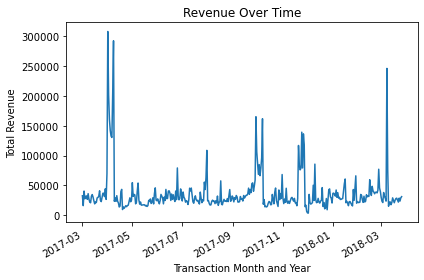

In [23]:
# Revenue over time
groupedByDate = cleanData.groupby('Conv_Date')
groupedByDate['Revenue'].sum().plot()
plt.title('Revenue Over Time')
plt.xlabel('Transaction Month and Year')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('visualizations/Revenue_Over_Time.png', dpi=600)
plt.show()

In [24]:
# Fraction of return cutomers
fracReturnCustomers = (cleanData.groupby('User_ID')['Conv_ID'].nunique() > 1).sum() / cleanData.User_ID.nunique()
print('Fraction of return cutomers is {:.2f} %'.format(fracReturnCustomers * 100))

Fraction of return cutomers is 16.12 %


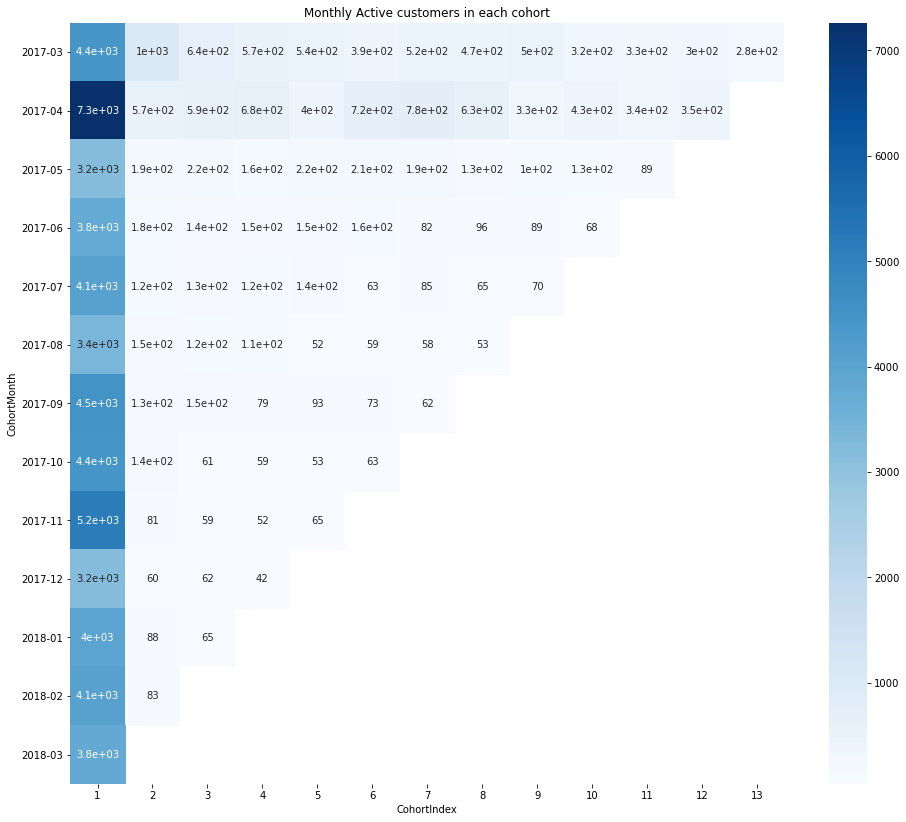

In [25]:
# Monthly Active customers in each cohort
# groupby(['CohortMonth', 'CohortIndex']
grouping = cleanData.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['User_ID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='User_ID')

cohort_counts.index = cohort_counts.index.to_period('M')
plt.figure(figsize=(16, 14))
plt.title('Monthly Active customers in each cohort')
sns.heatmap(data=cohort_counts, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.show()

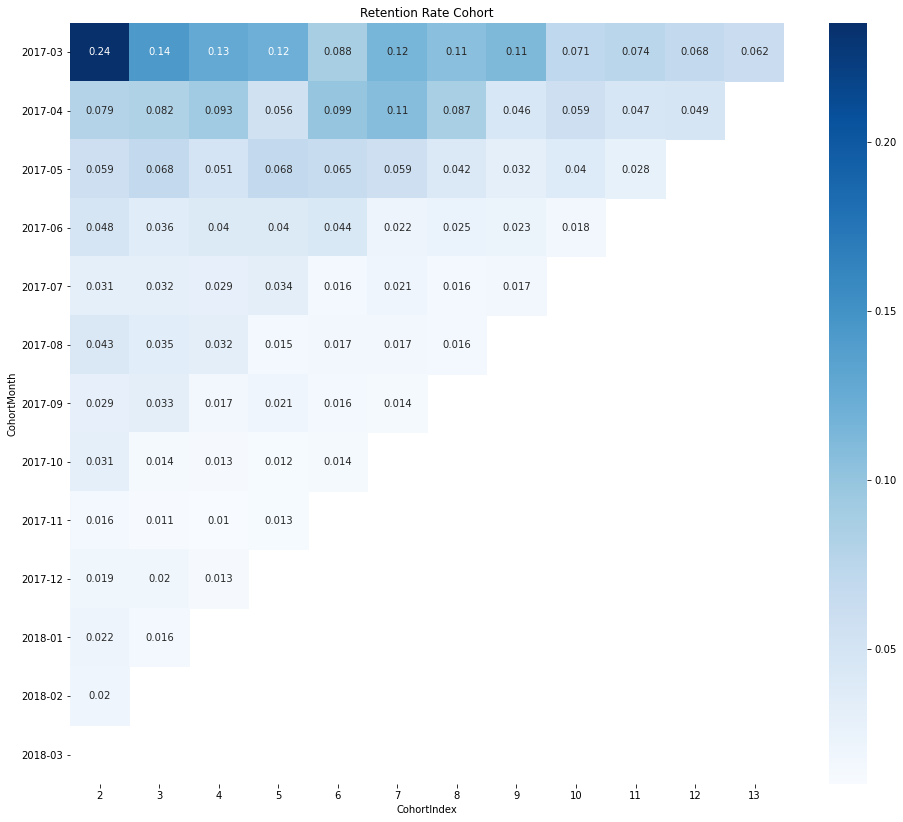

In [26]:
# Retention Rate Cohort
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
plt.figure(figsize=(16, 14))
plt.title('Retention Rate Cohort')
sns.heatmap(data=retention.iloc[:, 1:], annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.show()

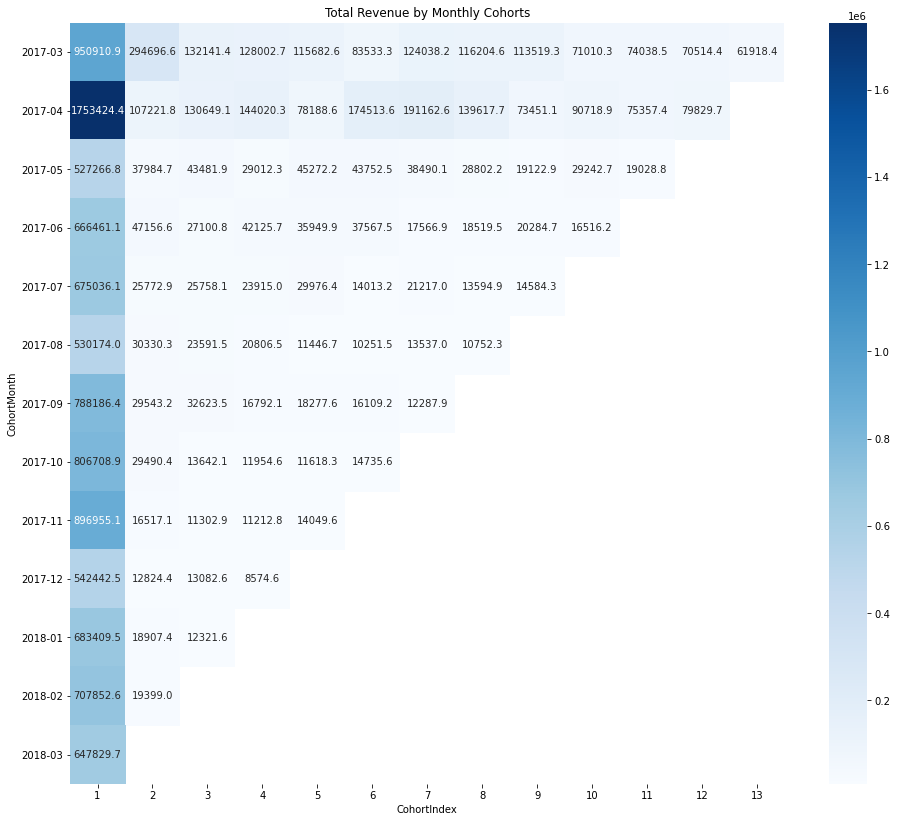

In [27]:
# Calculate total revenue by Monthly Cohorts
grouping = cleanData.groupby(['CohortMonth', 'CohortIndex']) 
cohort_data = grouping['Revenue'].sum()
cohort_data = cohort_data.reset_index()
average_revenue = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Revenue')
average_revenue.index = average_revenue.index.to_period('M')
plt.figure(figsize=(16, 14))
plt.title('Total Revenue by Monthly Cohorts')
sns.heatmap(data=average_revenue, annot=True, fmt=".1f", cmap='Blues')
plt.yticks(rotation=0)
plt.show()

In [28]:
# RFMT segmentation
# Recency - R - days since last customer transaction
# Frequency - F - number of transactions in the last 13 months
# Monetary Value - M - total spend in the last 13 months
# Tenure - T - time since the first transaction

dataPerUID = cleanData.groupby(['User_ID'])

recency = lambda x: (snapshot_date - x.max()).days
tenure = lambda x: (snapshot_date - x.min()).days

datamart = dataPerUID.agg(
    Recency = ('InvoiceDay', recency),
    Frequency = ('Conv_ID', 'count'),
    MonetaryValue = ('Revenue', sum),
    Tenure = ('InvoiceDay', tenure))
datamart.head()

,Recency,Frequency,MonetaryValue,Tenure
User_ID,,,,
00003ce67d6b73b2d49f4036f60cb73385a9c96e,146,1,153.840,146
0003509d64606735e66a3d32f2a1a084f613ee4b,89,2,245.632,142
00035f943a8a8e176fdd5a44059b38dcc0c73f5a,38,2,833.164,275
0003f10010cd3dadcb7182ed7b0abf5166393e91,287,1,121.808,287
0003fc733e4ff3bfb295f2c10c7077fb0763ebcc,28,1,108.720,28


In [29]:
# build IHC per user
grouped = dataPerUID.agg({i:['mean'] for i in chToKeep}).fillna(0)
grouped.columns = ["_".join(x) for x in grouped.columns]
grouped.head()

,A_mean,G_mean,H_mean,I_mean,B_mean
User_ID,,,,,
00003ce67d6b73b2d49f4036f60cb73385a9c96e,0.302910,0.155305,0.170037,0.0,0.0
0003509d64606735e66a3d32f2a1a084f613ee4b,0.000000,1.000000,0.000000,0.5,0.0
00035f943a8a8e176fdd5a44059b38dcc0c73f5a,0.231401,0.280338,0.319150,0.0,0.0
0003f10010cd3dadcb7182ed7b0abf5166393e91,0.000000,1.000000,0.000000,0.0,0.0
0003fc733e4ff3bfb295f2c10c7077fb0763ebcc,1.000000,0.000000,0.000000,0.0,0.0


In [30]:
# RFMTIHC
rfmtihc = datamart.merge(grouped, left_on=datamart.index, right_on=grouped.index)

In [31]:
rfmtihc.describe()

,Recency,Frequency,MonetaryValue,Tenure,A_mean,G_mean,H_mean,I_mean,B_mean
count,55332.000000,55332.000000,55332.000000,55332.000000,55332.000000,55332.000000,55332.000000,55332.000000,55332.000000
mean,175.273097,1.397365,254.436515,201.697752,0.253784,0.249350,0.160083,0.108964,0.116800
std,111.425380,1.373119,346.593552,117.266772,0.349686,0.361218,0.303244,0.232954,0.265793
min,1.000000,1.000000,24.646960,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79.000000,1.000000,114.899000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,171.000000,1.000000,167.160000,194.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,266.000000,1.000000,258.081000,308.000000,0.480074,0.461224,0.170721,0.045917,0.000000
max,391.000000,111.000000,29117.303120,391.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# We can notice that there are some outliers which will affect segmantation specially in frequency feature
# which has from 0 till 75% are the same and we won't be able to split this feauture in equal quartiles
# I'll exclude the top 1% of data which are most probably outliers and perform then splitting

In [33]:
rfmtihc.to_csv('data/rfmtihc.csv')

In [34]:
rfmtihc.mean(axis=0)

Recency          175.273097
Frequency          1.397365
MonetaryValue    254.436515
Tenure           201.697752
A_mean             0.253784
G_mean             0.249350
H_mean             0.160083
I_mean             0.108964
B_mean             0.116800
dtype: float64

In [35]:
rfmtihc.median(axis=0)

Recency          171.00
Frequency          1.00
MonetaryValue    167.16
Tenure           194.00
A_mean             0.00
G_mean             0.00
H_mean             0.00
I_mean             0.00
B_mean             0.00
dtype: float64

In [36]:
cleanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77319 entries, 0 to 77318
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Conv_ID         77319 non-null  object        
 1   Conv_Date       77319 non-null  datetime64[ns]
 2   Revenue         77319 non-null  float64       
 3   User_ID         77319 non-null  object        
 4   A               40484 non-null  float64       
 5   B               22078 non-null  float64       
 6   G               36024 non-null  float64       
 7   H               28745 non-null  float64       
 8   I               23885 non-null  float64       
 9   InvoiceDay      77319 non-null  datetime64[ns]
 10  CohortDay       77319 non-null  datetime64[ns]
 11  CohortDayIndex  77319 non-null  int64         
 12  InvoiceMonth    77319 non-null  datetime64[ns]
 13  CohortMonth     77319 non-null  datetime64[ns]
 14  CohortIndex     77319 non-null  int64         
dtypes:

In [37]:
# Basic CLV calculation
# Calculate monthly spend per customer
monthly_revenue = cleanData.groupby(['User_ID','InvoiceMonth'])['Revenue'].sum().mean()
# Calculate average monthly spend
monthly_revenue = np.mean(monthly_revenue)
# Define lifespan to 36 months
lifespan_months = 36
# Calculate basic CLV
clv_basic = monthly_revenue * lifespan_months
# Print basic CLV value
print('Average basic CLV is {:.1f} $ based on a lifespan of {} months'.format(clv_basic, lifespan_months))

Average basic CLV is 6960.8 $ based on a lifespan of 36 months


In [38]:
# Granular CLV calculation
# Calculate average revenue per invoice
revenue_per_purchase = cleanData.groupby(['Conv_ID'])['Revenue'].mean().mean()
# Calculate average number of unique invoices per customer per month
freq = cleanData.groupby(['User_ID','InvoiceMonth'])['Conv_ID'].nunique().mean()
# Define lifespan to 36 months
lifespan_months = 36
# Calculate granular CLV
clv_granular = revenue_per_purchase * freq * lifespan_months
# Print granular CLV value
print('Average granular CLV is {:.1f} $ based on a lifespan of {} months'.format(clv_granular, lifespan_months))

Average granular CLV is 6960.8 $ based on a lifespan of 36 months


In [39]:
# Traditional CLV
# # Calculate monthly spend per customer
monthly_revenue = cleanData.groupby(['User_ID','InvoiceMonth'])['Revenue'].sum().mean()
# Calculate average monthly retention rate
retention_rate = retention_rate = retention.iloc[:,1:].mean().mean()
# Calculate average monthly churn rate
churn_rate = 1 - retention_rate
# Calculate traditional CLV
clv_traditional = monthly_revenue * (retention_rate / churn_rate)
# Print traditional CLV and the retention rate values
print('Average traditional CLV is {:.1f} $ at {:.1f} % retention_rate'.format(
clv_traditional, retention_rate*100))

Average traditional CLV is 10.0 $ at 4.9 % retention_rate


In [51]:
from helperFunctions.segmantation import *
# Exclude target variable
cleanData_X = cleanData[cleanData.InvoiceMonth != cleanData.InvoiceMonth.max()]
# Define snapshot date
NOW = cleanData.InvoiceMonth.max()
features1 = build_rfmt(cleanData_X, NOW, 'User_ID')
features2 = build_ihc(cleanData_X, chToKeep)
features = build_rfmt_ihc(features1, features2)
features = features[(features.MonetaryValue <= 1027.34) & (features.MonetaryValue > 24.65)].drop("Frequency", axis=1)

                                          Recency  Frequency  MonetaryValue  \
User_ID                                                                       
00003ce67d6b73b2d49f4036f60cb73385a9c96e      120          1        153.840   
0003509d64606735e66a3d32f2a1a084f613ee4b       63          2        245.632   
00035f943a8a8e176fdd5a44059b38dcc0c73f5a       12          2        833.164   
0003f10010cd3dadcb7182ed7b0abf5166393e91      261          1        121.808   
0003fc733e4ff3bfb295f2c10c7077fb0763ebcc        2          1        108.720   

                                          Tenure  
User_ID                                           
00003ce67d6b73b2d49f4036f60cb73385a9c96e     120  
0003509d64606735e66a3d32f2a1a084f613ee4b     116  
00035f943a8a8e176fdd5a44059b38dcc0c73f5a     249  
0003f10010cd3dadcb7182ed7b0abf5166393e91     261  
0003fc733e4ff3bfb295f2c10c7077fb0763ebcc       2  
                                                 A         G         H    I  \
User_ID   

In [52]:
features.head()

,key_0,Recency,MonetaryValue,Tenure,A,G,H,I,B
0,00003ce67d6b73b2d49f4036f60cb73385a9c96e,120,153.8400,120,0.302910,0.155305,0.170037,0.00000,0.0
1,0003509d64606735e66a3d32f2a1a084f613ee4b,63,245.6320,116,0.000000,1.000000,0.000000,0.50000,0.0
2,00035f943a8a8e176fdd5a44059b38dcc0c73f5a,12,833.1640,249,0.231401,0.280338,0.319150,0.00000,0.0
3,0003f10010cd3dadcb7182ed7b0abf5166393e91,261,121.8080,261,0.000000,1.000000,0.000000,0.00000,0.0
4,0003fc733e4ff3bfb295f2c10c7077fb0763ebcc,2,108.7200,2,1.000000,0.000000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...
51516,fffad529f49901b6d0af0badf98ae02108028cdc,359,146.5884,359,0.000000,0.000000,1.000000,0.00000,0.0
51517,fffb0fc0e6cde8d4838713679c0a6d3c28087671,83,97.3360,83,0.000000,1.000000,0.000000,0.00000,0.0
51518,fffc3a37495e0f44dbfe4511ec0d46460aa571e5,119,148.1440,119,0.000000,0.363101,0.336859,0.30004,0.0
51519,fffc95150d63e98e62d98cdfabbf13245fdc2dd2,87,210.8000,87,1.000000,0.000000,0.000000,0.00000,0.0


In [90]:
# Build a pivot table counting invoices for each customer monthly
cust_month_tx = pd.pivot_table(data=cleanData, values='Conv_ID',
                               index=['User_ID'], columns=['InvoiceMonth'],
                               aggfunc=pd.Series.nunique, fill_value=0)

target = cleanData.InvoiceMonth.max()

y = cust_month_tx[target]
y_valid_ind = [row for row in y.index.to_list() if row in features['key_0'].to_list()]
y = y[y_valid_ind]

In [65]:
# Split data to training and testing
# Store customer identifier column name as a list
custid = ['key_0']

# Select feature column names excluding customer identifier
cols = [col for col in features.columns if col not in custid]

# Extract the features as `X`
X = features[cols]

In [91]:
# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [98]:
# Predicting customer transactions
# R-squared - statistical measure that represents the percentage proportion of variance that is explained by the model.
# Coef P-val - probability that the regression coefs observed due to chance (measure of statistical significance)
# typical threashold are 5% or 10%
pow_trans = PowerTransformer()
linreg = LinearRegression()
steps = [('power_transformation', pow_trans), ('linear_rergession', linreg)]
pipeline = Pipeline(steps=steps)
        
pipeline.fit(X_train, y_train)
train_pred_y = pipeline.predict(X_train)

# Predict the target variable for testing data
test_pred_y = linreg.predict(X_test)

In [138]:
# Predicting customer transactions
# R-squared - statistical measure that represents the percentage proportion of variance that is explained by the model.
# Coef P-val - probability that the regression coefs observed due to chance (measure of statistical significance)
# typical threashold are 5% or 10%
linreg = LinearRegression()
        
linreg.fit(X_train, y_train)
train_y_pred = linreg.predict(X_train)

# Predict the target variable for testing data
test_y_pred = linreg.predict(X_test)

In [139]:
# Calculate root mean squared error on training data
rmse_train = np.sqrt(mean_squared_error(y_train, train_y_pred))

# Calculate mean absolute error on training data
mae_train = mean_absolute_error(y_train, train_y_pred)

# Calculate root mean squared error on testing data
rmse_test = np.sqrt(mean_squared_error(y_test,test_y_pred))

# Calculate mean absolute error on testing data
mae_test = mean_absolute_error(y_test,test_y_pred)

# Print the performance metrics
print('RMSE train: {}; RMSE test: {}\nMAE train: {}, MAE test: {}'.format(rmse_train, rmse_test, mae_train, mae_test))
print('Test r2: ', round(r2_score(y_test, test_y_pred),4))

RMSE train: 0.1464754378467411; RMSE test: 0.15721296117534553
MAE train: 0.0392831706098676, MAE test: 0.0397795373372464


In [148]:
{key:linreg.coef_[i] for i, key in enumerate(X.columns.to_list())}

{'Recency': -0.00031425851586367023,
 'MonetaryValue': 0.00010995748100065257,
 'Tenure': 0.0002667542914476375,
 'A': -0.0009236291308203372,
 'G': -0.004147250029675973,
 'H': -0.002282267917434469,
 'I': -0.002848069710195581,
 'B': 0.0022288145409838957}